In [1]:
import numpy as np
import pulp as plp
import random
import matplotlib.pyplot as plt
import time
import networkx as nx

In [5]:
def Create_Points(n,m,plot=False,base="star"):
    
    a = 2
    
    #basis = np.array([[0,0],[a/2,0],[a/4,np.sqrt(3)/2],[0,np.sqrt(3)],[a/2,np.sqrt(3)]])
    #basis2 = np.array([[0,0],[a/2,0],[a/4,np.sqrt(3)/2]])
    #basis3 = np.array([[a/4,np.sqrt(3)/2],[0,np.sqrt(3)],[a/2,np.sqrt(3)]])
    
    triangle_basis = np.array([[0,0],[a/2,0],[a/4,np.sqrt(3)/2]])

    hexagon_basis = np.array([[a/4,np.sqrt(3)/2],[a/2,np.sqrt(3)]
                    ,[a,np.sqrt(3)],[a,0],[a/2,0],
                    [5*1/4*a,np.sqrt(3)/2]])

    star_basis = np.array([[0,0],[a/2,0],[a/4,np.sqrt(3)/2],[0,np.sqrt(3)],[a/2,np.sqrt(3)],
                     [3/4*a,3/2*np.sqrt(3)],[a,np.sqrt(3)],[a,0],
                     [3/4*a,-np.sqrt(3)/2],
                     [3/2*a,0],[3/2*a,np.sqrt(3)],
                     [5*1/4*a,np.sqrt(3)/2]])
    if base == "triangle":
        basis = triangle_basis
    
    if base == "hexagon":
        basis = hexagon_basis
    if base == "star":
        basis = star_basis
    
    vec = np.array([[a,0],[a/2,a*np.sqrt(3)/2]])
    
    rows=m
    cols=n
    """
    vectors = [(0,0)]
    
    vectors = []
    for i in range(0,n+1):
         vectors.append((i,0))
    for i in range(1,n+1):
         vectors.append((i,-1))     
    for i in range(0,n):
         vectors.append((i,1))
    """        

    points=[]
    
    vectors=[(j,i) for i in range(0,rows) for j in range(0,cols)]
    """
    vectors = [(0,-1),(1,-1),
              (0,0),(1,0),
              (0,1),(1,1)]
    """
    vectors = sorted(vectors,key=lambda l:l[1])
    
    #print(vectors)
    
    for v in vectors:
        point = basis + v[0]*vec[0,:] + v[1]*vec[1,:]
        points.append(point)  
     
    points=np.array(points)

    POINTS= []
    for v in points:
        for a,b, in v:
            POINTS.append([a,b])

    lista = np.unique(np.round(POINTS,7), axis=0)
          
    #############################################################################
    
    if plot==True:
        fig, ax = plt.subplots(figsize=(10,10))
        x, y = np.array(lista).T

        ax.scatter(x,y)
        
        for i in range(-100,100):
            plt.axline((i, 0), slope=np.sqrt(3), color="black",alpha=0.3,linestyle='--', linewidth='1') #linestyle=(0, (5, 5)))
        for i in range(-100,100):
            plt.axline((i, 0), slope=-np.sqrt(3), color="black",alpha=0.3,linestyle='--', linewidth='1') #linestyle=(0, (5, 5)))
        for i in range(-100,100):
            plt.axline((0, np.sqrt(3)/2*i), slope=0,color="black",alpha=0.3,linestyle='--', linewidth='1')

        ax.set_xlim(xmin=min(x)-n,xmax=max(x)+n)
        ax.set_ylim(ymin=min(y)-n,ymax=max(y)+n)
        plt.grid(alpha=0.3)
        
        plt.show()
    
    #############################################################################
    
    return lista

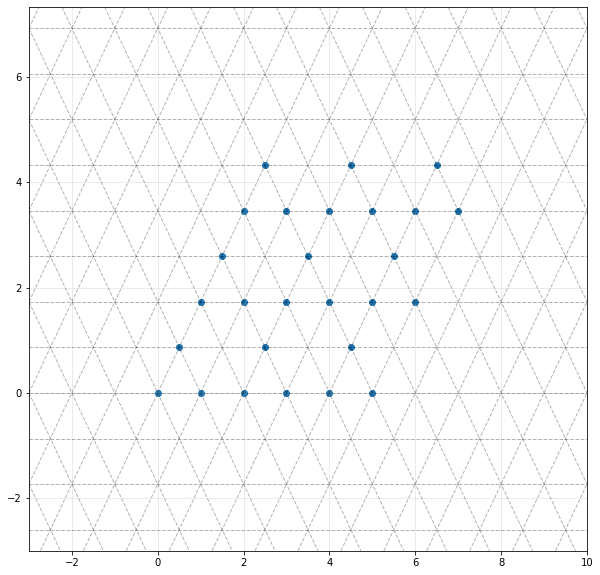

In [6]:
points = Create_Points(3,3,plot=True,base="triangle")

# LATTICE

In [228]:
def my_path_graph(n):
    
    G = nx.Graph()

    G.add_nodes_from(range(n))
    
    for v in range(n-1):
        G.add_edge((v),(v+1),weight=0)
    
    return G

def my_grid_graph(dim):

    colors=[]
    dim=list(dim)
    current_dim=dim.pop()
    G=my_path_graph(current_dim)

    
    while len(dim)>0:
        current_dim=dim.pop()
        Gold=G.copy()
        Gnew=my_path_graph(current_dim)

        G=nx.cartesian_product(Gnew,Gold)

    H=nx.relabel_nodes(G, nx.utils.flatten)

    return H

In [186]:
def create_grid_lattice_graph(n,m,k=0.0,plot=False):

    G,dic = my_grid_graph(dim=[n,m],k=k)
    
    ##################################################################################
    if plot==True:
        colors=[]
        for a,b,d in G.edges.data():
            if d["weight"]==1:
                colors.append("green")
            else:
                colors.append("red")

        pos = dict( (n, n) for n in G.nodes() )
        fig, ax = plt.subplots(figsize=(8,8))
        nx.draw(G,pos,node_size=10,edge_color=colors,node_color="black",with_labels=True)
    ##################################################################################
    
    
    #signed_matrix0 = nx.to_numpy_matrix(G)

    return G

In [152]:
def Plot_Colors(G,points):
    colors=[]
    for a,b,d in G.edges.data():
        if d["weight"]==1:
            colors.append("green")
        else:
            colors.append("red")

    pos = {k: v for k,v in zip(G.nodes(), points)}
    fig, ax = plt.subplots(figsize=(8,8))
    nx.draw(G,pos,node_size=10,edge_color=colors,node_color="black",with_labels=True)

In [153]:
def Create_Data(matrices):

    signed_matrices=[]
    unsigned_matrices=[]
    weights = []
    graphs=[]
    for signed_matrix in matrices:

        Graph=nx.from_numpy_matrix(signed_matrix)

        mapping=dict(zip(Graph.nodes(),range(len(Graph.nodes()))))
        Graph=nx.relabel_nodes(Graph,mapping) 

        graphs.append(Graph)

        signed_matrix = nx.to_numpy_matrix(Graph)
        unsigned_matrix = abs(signed_matrix)    

        weighted_edges=nx.get_edge_attributes(Graph, 'weight') 
        w={}
        for (u,v) in weighted_edges:
            if u<v:
                w[(u,v)] = weighted_edges[(u,v)]
            if u>v:
                w[(v,u)] = weighted_edges[(u,v)]

        signed_matrices.append(signed_matrix)
        unsigned_matrices.append(unsigned_matrix)
        weights.append(w)

    return graphs, weights, signed_matrices

In [154]:
def XOR_Model(graphs, weights, signed_matrix):

    objectivevalue=[]
    objs=[]
    solveTime=[]
    
    run = len(graphs)
    
    speedupParam=int(1)
    
    for index in range(run):
      
        ##############################################################
        
        order=len(signed_matrix[index])
        negative_edges=((-1 == signed_matrix[index])).sum()/2
        size=int(np.count_nonzero(signed_matrix[index])/2)

        neighbors={}
        Degree=[]
        for u in sorted((graphs[index]).nodes()):
            neighbors[u] = list((graphs[index])[u])
            Degree.append(len(neighbors[u]))
        unsignedDegree=Degree
        
        #Finding the node with the highest unsigned degree
        maximum_degree = max(unsignedDegree)
        [node_to_fix]=[([i for i, j in enumerate(unsignedDegree) if j == maximum_degree]).pop()]
        
        GraphTriangles=[]
        for n1 in sorted((graphs[index]).nodes()):
            neighbors1 = set((graphs[index])[n1])
            for n2 in filter(lambda x: x>n1, neighbors1):
                neighbors2 = set((graphs[index])[n2])
                common = neighbors1 & neighbors2
                for n3 in filter(lambda x: x>n2, common):
                    GraphTriangles.append([n1,n2,n3])
                    
        w=nx.get_edge_attributes(graphs[index], 'weight')  
        unbalanced_triangles = []
        balanced_triangles = []
        for triad in GraphTriangles: 
            if  (weights[index])[(triad[0],triad[1])]*\
            (weights[index])[(triad[0],triad[2])]*(weights[index])[(triad[1],triad[2])] == -1:
                unbalanced_triangles.append(triad)
            elif (weights[index])[(triad[0],triad[1])]*\
            (weights[index])[(triad[0],triad[2])]*(weights[index])[(triad[1],triad[2])] == 1:
                balanced_triangles.append(triad)  
        
        ##############################################################
        
        order=len(signed_matrix[index])
        
        opt_model = plp.LpProblem(name="Binary_Model",sense = plp.LpMinimize)

        x=[]
        for i in range(0,order):
            x.append(plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='x'+str(i)))

        z={}    
        for (i,j) in (weights[index]):
            z[(i,j)]=plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='z'+str(i)+','+str(j))
        
        OFV = 0
        for (i,j) in (weights[index]):
            OFV += z[(i,j)]
            
        opt_model.setObjective(OFV)
                    
        for (i,j) in (weights[index]):
            opt_model.addConstraint( z[(i,j)] >= x[i] - ((weights[index])[(i,j)])*x[j] -\
                            (1-(weights[index])[(i,j)])/2)
            opt_model.addConstraint( z[(i,j)] >= -x[i] + ((weights[index])[(i,j)])*x[j] +\
                            (1-(weights[index])[(i,j)])/2)   
                    
        ###############################################################################################
    
        if speedupParam==1:
            
            lazyTriangles=int(2)

            if lazyTriangles == 2:
                triangleInequalityCount=len(unbalanced_triangles)
                for triangle in unbalanced_triangles:
                    [i,j,k]=triangle
                    opt_model.addConstraint(z[(i,j)] + z[(i,k)] + z[(j,k)] >= 1)
                    
            elif lazyTriangles == 3:
                triangleInequalityCount=0

            # Colour the node with the highest degree as 1
            opt_model.addConstraint(x[node_to_fix]==1)   
        
        #####################################################################################

        #for runda in range(10):
        
        #print("starting solver")
                    
        start_time = time.time()
        status = opt_model.solve(solver = plp.getSolver('GUROBI_CMD'))#'COIN_CMD'))
        solveTime.append(time.time() - start_time) 
        
        #print("solve time",solveTime[index])

        #print("object=",opt_model.objective.value())
        
        obj = float(opt_model.objective.value())
        objectivevalue.append((obj))
            
        #objs.append((np.mean(objectivevalue),np.std(objectivevalue)))        
                    
    return objectivevalue, solveTime

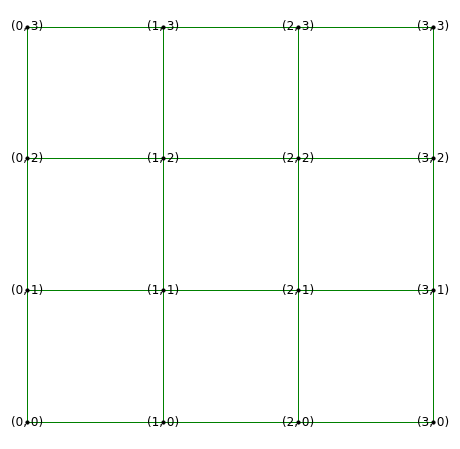

In [155]:
G = create_grid_lattice_graph(4,4,k=0.0,plot=True)

In [254]:
def Rewire_Grid(G,p):
    #print("enter rewire")
    nukem=[]
    addem=[]
    xmaks = (max(G.nodes())[0])
    ymaks = (max(G.nodes())[1])
    for node in G.nodes():
        #print("stari",node)
        for edge in nx.edges(G,node):
            r = random.uniform(0, 1)
            if r<=p:
                nukem.append(edge)
                    
                x = random.randint(0,xmaks)
                #print(x)
                y = random.randint(0,ymaks)
                #print(y)
                new_node = (x,y)
                #print("new",new_node)
                
                if new_node in G.nodes() and new_node!=node:
                    #print("dodajem")
                    addem.append((node,new_node))
                else:
                    #print("nije uspio odmah")
                    while new_node not in G.nodes() and new_node!=node:
                        x = random.randint(0,xmaks)
                        y = random.randint(0,ymaks)
                        new_node=(x,y)
                addem.append((node,new_node))
        
    #print("removing")
    G.remove_edges_from(nukem)
    #print("adding")
    G.add_edges_from(addem)
    #print("exit rewire")
    return G

In [244]:
def Add_Grid_Weights(H,k):
      
    N = len(H.edges())

    n=int(round(k*N))
    m=int(round((1-k)*N))

    a = np.ones(n+m)
    a[:m] = -1
    np.random.shuffle(a)
    
    dic={}
    for e,value in zip(H.edges(),a):
        dic[e] = value
    
    nx.set_edge_attributes(H, dic, "weight")
    
    return H

enter rewire
exit rewire


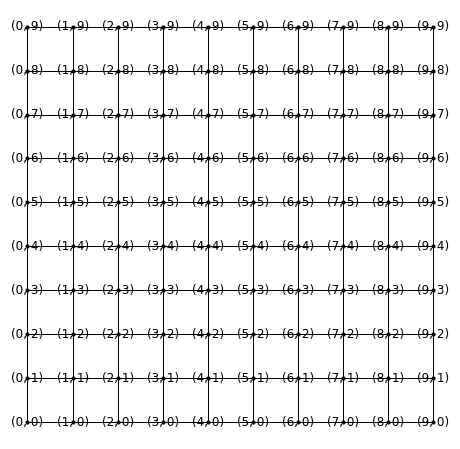

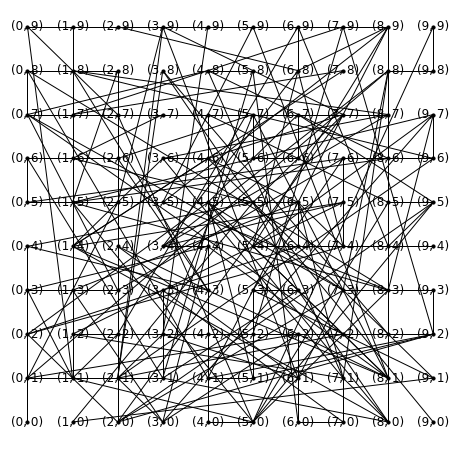

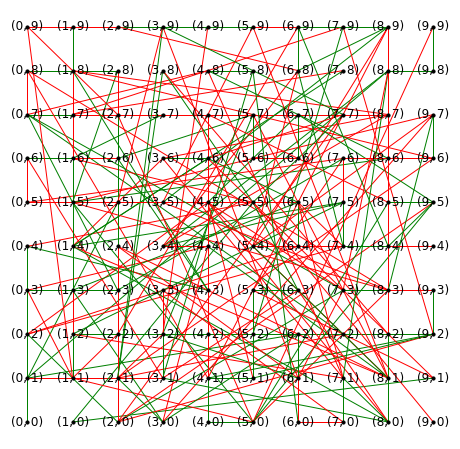

In [246]:

G = my_grid_graph(dim=[10,10])


pos = dict( (n, n) for n in G.nodes() )
fig, ax = plt.subplots(figsize=(8,8))
nx.draw(G,pos,node_size=10,node_color="black",with_labels=True)


G = Rewire_Grid(G,0.5)

pos = dict( (n, n) for n in G.nodes() )
fig, ax = plt.subplots(figsize=(8,8))
nx.draw(G,pos,node_size=10,node_color="black",with_labels=True)

G = Add_Grid_Weights(G,0.5)

Plot_Colors(G,dict( (n, n) for n in G.nodes() ))

In [220]:
#nx.set_edge_attributes(G, dic, "weight")

In [247]:
def Coloring_Function(size = 5, repeat = 5):
    
    K = np.linspace(0,1)
    
    total=[]
    for index, k in enumerate(K):
        print(index,end=" ")
        results = []
        for numb,i in enumerate(range(repeat)):
            
            #G = create_grid_lattice_graph(size,size,k=k,plot=False)
            
            G = my_grid_graph(dim=[size,size])
            
            G = Add_Grid_Weights(G,k)

            signed_matrix0 = nx.to_numpy_matrix(G)

            graphs, weights, signed_matrices = Create_Data([signed_matrix0])

            objs0,solve_time0 = XOR_Model(graphs, weights, signed_matrices)

            results.append(objs0)
            
        total.append((np.mean(results),np.std(results)))

    fig, ax = plt.subplots(figsize=[8,8])
    ax.errorbar([k for k in K], [i for i,j in total], [j for i,j in total], ls='dotted', marker='^',capsize=10)
    plt.show()
    
    return total

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

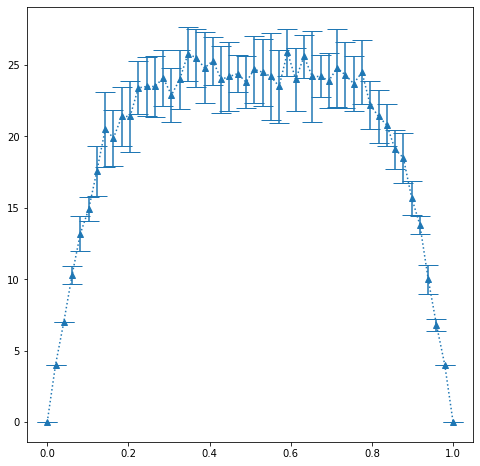

In [248]:
total = Coloring_Function(size = 10, repeat = 10)

In [259]:
def Rewiring_Fuction(size = 5, repeat = 5, k=1):

    P = np.linspace(0,1)

    total=[]
    NUM = size
    for index, p in enumerate(P):
        print(index,end=" ")
        #print("\n",k)
        results = []
        for numb,i in enumerate(range(repeat)):
            #print(numb,end=" ")
            
            G = my_grid_graph(dim=[size,size])
            
            G = Rewire_Grid(G,p)
            
            G = Add_Grid_Weights(G,0.5)

            signed_matrix0 = nx.to_numpy_matrix(G)

            graphs, weights, signed_matrices = Create_Data([signed_matrix0])

            objs0,solve_time0 = XOR_Model(graphs, weights, signed_matrices)

            results.append(objs0)

            #print("\nresults=",np.mean(objs0),np.std(objs0))
            #print("time=",np.mean(solve_time0),np.std(solve_time0))
        total.append((np.mean(results),np.std(results)))
        
    fig, ax = plt.subplots(figsize=[8,8])
    ax.errorbar([p for p in P], [i for i,j in total], [j for i,j in total], ls='dotted', marker='^',capsize=10)
    plt.show()
    
    return total

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

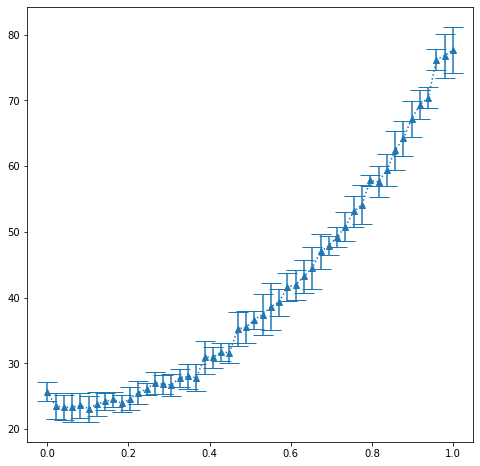

In [260]:
total = Rewiring_Fuction(size = 10, repeat = 10)